In [1]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
import random

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Predictive
from pyro.ops.indexing import Vindex
from pyro.infer import MCMC, NUTS

## Data preparation and cleaning
# importing required packages
import pyreadr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 30

import umap
import plotly
import plotly.graph_objs as go

import pickle

import torch.nn.functional as F

pyro.enable_validation(True)

Autosaving every 30 seconds


# Data preparation and visualization

In [2]:
# import data and convert to python objects
# load Rdata object
rdata = pyreadr.read_r('tomtom_data/det_dfs.Rdata')
# pull out separate dataframes, one with choice text, the other with numeric responses
df = rdata['df']
dfn = rdata['dfn']
df.head()


# read in state labels
states = pd.read_csv('tomtom_data/states.csv')
states['statepair'] = states['state1'] + '_' + states['state2']# construct state pair strings
states.head()

# extract all the self ratings
ind_selfq1 = df.columns.get_loc('X1_Q12_1') # location of the first question
trans_self = df.iloc[:,list(range(ind_selfq1,(ind_selfq1+75)))]
print('shape of self-rating dataframe: ',trans_self.shape)
trans_self.columns = states['statepair'].tolist() # renaming transitioin columns with the corresponding transition pairs
#print(trans_self.columns[1:5])
#trans_self.head()
# extract all the specific target ratings
ind_targq1 = df.columns.get_loc('X1_Q9_1') # location of the first question
trans_targ = df.iloc[:,list(range(ind_targq1,(ind_targq1+75)))]
print('shape of target-rating dataframe: ', trans_targ.shape)
trans_targ.columns = states['statepair'].tolist() # renaming transitioin columns with the corresponding transition pairs
#print(trans_targ.columns[1:5])
#trans_targ.head()
# extract all the group level ratings
ind_avgq1 = df.columns.get_loc('X1_Q11_1') # location of the first question
trans_avg = df.iloc[:,list(range(ind_avgq1,(ind_avgq1+75)))]
print('shape of group-rating dataframe: ', trans_avg.shape)
trans_avg.columns = states['statepair'].tolist() # renaming transitioin columns with the corresponding transition pairs
#print(trans_avg.columns[1:5])
#trans_targ.head()

shape of self-rating dataframe:  (94, 75)
shape of target-rating dataframe:  (94, 75)
shape of group-rating dataframe:  (94, 75)


In [3]:
# inspect the "spread" of target vs group ratings using pairwise correlation between subjects
# getting pairwise correlations
trans_self_corbtsub = trans_self.transpose().corr()
trans_targ_corbtsub = trans_targ.transpose().corr()
trans_avg_corbtsub = trans_avg.transpose().corr()

# get the mean pairwise correlation for each of the three sets of correlations
def mean_pairwise_corr(corbtsub):
    corbtsub = np.array(corbtsub)
    corbtsub_flat = corbtsub[np.tril_indices(corbtsub.shape[0],-1)] # gett lower triangle and flatten
#     print(corbtsub_flat.shape)
    return corbtsub_flat, np.nanmean(corbtsub_flat)

trans_self_pairwiseflat, trans_self_meanpairwise = mean_pairwise_corr(trans_self_corbtsub)
trans_targ_pairwiseflat, trans_targ_meanpairwise = mean_pairwise_corr(trans_targ_corbtsub)
trans_avg_pairwiseflat, trans_avg_meanpairwise = mean_pairwise_corr(trans_avg_corbtsub)

print('The spread of self ratings: ', trans_self_meanpairwise)
print('The spread of target ratings: ', trans_targ_meanpairwise)
print('The spread of group ratings: ', trans_avg_meanpairwise)

scipy.stats.ttest_rel(trans_targ_pairwiseflat,trans_avg_pairwiseflat, nan_policy='omit')

The spread of self ratings:  0.5710433236550672
The spread of target ratings:  0.5042138201358816
The spread of group ratings:  0.6135978109836753


Ttest_relResult(statistic=-44.555126397363594, pvalue=0.0)

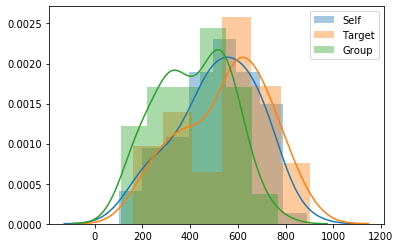

In [4]:
# Additional way to look at the spread of specific vs group: looking at the variance for each of the items
# the graph shows less spread at the item level for group ratings than for self or target specific ratings.
itemvar_trans_self = trans_self.var(axis = 0)
itemvar_trans_targ = trans_targ.var(axis = 0)
itemvar_trans_avg = trans_avg.var(axis = 0)

sns.distplot(itemvar_trans_self, label='Self')
sns.distplot(itemvar_trans_targ, label='Target')
sns.distplot(itemvar_trans_avg, label='Group')
plt.legend()
plt.show()

In [5]:
# reusable code for pre processing each of the three sets of ratings into pyro compatible format

# altering edge values to avoid rounding errors while sampling
def de_edge_raw(t):
    t[t == 0] = .0001
    t[t == 1] = .9999
    return t

def de_edge_norm(t):
    ## in the normed data there's no 1s
    # change 0 to .0001 and decrement the max value of the same row by .0001 
    # in order to make sure the row still sums to 1
    ind_zero = np.where(t == 0)
    t[ind_zero] += .0001
    ind_max = np.argmax(t,axis = 2)
    for i in np.arange(ind_zero[0].shape[0]):
        temp_max = ind_max[ind_zero[0][i],ind_zero[1][i]]
        t[ind_zero[0][i],ind_zero[1][i],temp_max] -= .0001
    return t

def data_transform(trans):
    # set the constant for converting probability to frequency
    freq_constant = 10000
    # indexing autotransition columns
    colnames = trans.columns.tolist()
    cnsplit = [p.split('_') for p in colnames]
    idx_autotransition = [p[0] == p[1] for p in cnsplit] # list of boolean, True = is autotransition
    
    # 1. normalizing with autotransitions included, one df for probability, one converted to frequency
    # initialize 2 dataframes
    t_norm_all = pd.DataFrame(columns=trans.columns, index = trans.index)
    t_norm_all_f =  pd.DataFrame(columns=trans.columns, index = trans.index)
    
    # normalize by row-sum every five columns, since the columns are already arranged by from-state in 5
    for i in range(0,trans.shape[1],5):
        dftemp = trans.iloc[:,i:(i+5)]
        dftemp_rowsum = dftemp.sum(axis = 1)
        normed_cols = dftemp/dftemp_rowsum[:,np.newaxis]
        t_norm_all.iloc[:,i:(i+5)] = normed_cols
        t_norm_all_f.iloc[:,i:(i+5)] = (normed_cols * freq_constant).round()
        
    # 2. two additional dataframes: normed with auto transition but don't contain them
    t_norm_all_noauto = t_norm_all.loc[:,[not t for t in idx_autotransition]]
    t_norm_all_noauto_f = t_norm_all_f.loc[:,[not t for t in idx_autotransition]]

    # 3. finally, normalizing without autotransitions, and also convert to frequency
    trans_noauto = trans.loc[:,[not t for t in idx_autotransition]]
    t_norm_noauto = pd.DataFrame(columns=trans_noauto.columns, index = trans_noauto.index)
    t_norm_noauto_f = pd.DataFrame(columns=trans_noauto.columns, index = trans_noauto.index)

    # normalize by row-sum every FOUR columns, grouped by from-state in 4 without autotransition
    for i in range(0,trans_noauto.shape[1],4):
        dftemp = trans_noauto.iloc[:,i:(i+4)]
        dftemp_rowsum = dftemp.sum(axis = 1)
        normed_cols = dftemp/dftemp_rowsum[:,np.newaxis]
        t_norm_noauto.iloc[:,i:(i+5)] = normed_cols
        t_norm_noauto_f.iloc[:,i:(i+5)] = (normed_cols * freq_constant).round()
        
    t_norm_all_3d = torch.tensor(np.stack([np.array(t_norm_all.iloc[i]).reshape(15,5) 
                                        for i in np.arange(t_norm_all.shape[0])]).astype('float32'))
    t_norm_noauto_3d = torch.tensor(np.stack([np.array(t_norm_noauto.iloc[i]).reshape(15,4) 
                                            for i in np.arange(t_norm_noauto.shape[0])]).astype('float32'))
    t_raw_all_3d = torch.tensor(np.stack([np.array(trans.iloc[i]).reshape(15,5) 
                                            for i in np.arange(trans.shape[0])]).astype('float32'))
    t_raw_noauto_3d = torch.tensor(np.stack([np.array(trans_noauto.iloc[i]).reshape(15,4) 
                                            for i in np.arange(trans_noauto.shape[0])]).astype('float32'))
    
    return de_edge_norm(t_norm_all_3d), de_edge_norm(t_norm_noauto_3d), de_edge_raw(t_raw_all_3d/100), de_edge_raw(t_raw_noauto_3d/100)
#     return t_norm_all_3d, t_norm_noauto_3d, de_edge(t_raw_all_3d/100), de_edge(t_raw_noauto_3d/100)


In [6]:
global tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d
global ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d
global tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d
tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d = data_transform(trans_self)
ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d = data_transform(trans_targ)
tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d = data_transform(trans_avg)


# Function definition

In [7]:
# define a model function that's dynamically declared

def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

@config_enumerate()
def model(data):
    # stick breaking process for assigning weights to groups
    with pyro.plate("beta_plate", K-1):
        beta_mix = pyro.sample("weights", dist.Beta(1, 10))
    
#     # Background probability of different groups (assume equally likely)
#     weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    # declare number of columns based on whether auto-transitions are included
    if auto == 'all':
        ncol = 5
    elif auto == 'noauto':
        ncol = 4
            
    # declare model parameters based on whether the data are row-normalized
    if norm == 'norm':
        with pyro.plate('components', K):
            # concentration parameters
            concentration = pyro.sample('concentration', 
                                        dist.Gamma(2 * torch.ones(15,ncol), 1/3 * torch.ones(15,ncol)).to_event(2))
        
        with pyro.plate('data', data.shape[0]):
            assignment = pyro.sample('assignment', dist.Categorical(mix_weights(beta_mix)))
            #d = dist.Dirichlet(concentration[assignment,:,:].clone().detach()) # .detach() might interfere with backprop
            d = dist.Dirichlet(concentration[assignment,:,:])
            pyro.sample('obs', d.to_event(1), obs=data)
            
    elif norm == 'raw':
        with pyro.plate('components', K):
            alphas = pyro.sample('alpha', dist.Gamma(2 * torch.ones(15,ncol), 1/3 * torch.ones(15,ncol)).to_event(2))
            betas = pyro.sample('beta', dist.Gamma(2 * torch.ones(15,ncol), 1/3 * torch.ones(15,ncol)).to_event(2))
            
        with pyro.plate('data', data.shape[0]):
            assignment = pyro.sample('assignment', dist.Categorical(mix_weights(beta_mix)))
            d = dist.Beta(alphas[assignment,:,:], betas[assignment,:,:])
            pyro.sample('obs', d.to_event(2), obs=data)

# function used to initialize model
def initialize(seed,model,data):    
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    if norm == 'norm':
        global_guide = AutoDelta(poutine.block(model, expose=['weights', 'concentration']))
    elif norm == 'raw':
        global_guide = AutoDelta(poutine.block(model, expose=['weights', 'alpha', 'beta']))
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

# packing code to read out (predict) cluster membership
def get_membership(model, guide, data, temperature=0):
    
    guide_trace = poutine.trace(global_guide).get_trace(data)  # record the globals
    trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals
    
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assignment"]["value"]
            
# define a code chunk that does the SVI step for singel variation
def tomtom_svi():
    pyro.clear_param_store()
    
    #declare dataset to be modeled
    dtname = 't{}_{}_{}_3d'.format(target, norm, auto)
    print("running SVI with: {}".format(dtname))
    data = globals()[dtname]
    
    loss, seed = min((initialize(seed,model,data), seed) for seed in range(100))
    initialize(seed,model,data)
    print('seed = {}, initial_loss = {}'.format(seed, loss))
    
    gradient_norms = defaultdict(list)
    for name, value in pyro.get_param_store().named_parameters():
        value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

    losses = []
    for i in range(3000):
        loss = svi.step(data)
        #print(loss)
        losses.append(loss)
        if i % 100 == 0:
            print('.',end = '')
#             print(loss)
    print('\n final loss: {}\n'.format(losses[-1]))

    map_estimates = global_guide(data)
    weights = map_estimates['weights']
    print('weights = {}'.format(weights.data.numpy()))
    print('mixed weights = {}'.format(mix_weights(weights)))
    if norm == 'norm':
        concentration = map_estimates['concentration']
        print('concentration = {}'.format(concentration.data.numpy()))
    elif norm == 'raw':
        alpha = map_estimates['alpha']
        print('alphas = {}'.format(alpha.data.numpy()))
        beta = map_estimates['beta']
        print('beta = {}'.format(beta.data.numpy()))
    
    membership = get_membership(model, global_guide, data, temperature = 0)
    
    return seed, map_estimates, membership

def tomtom_mcmc(seed,nsample = 5000, burnin = 1000):
    pyro.clear_param_store()
    pyro.set_rng_seed(seed)

    #declare dataset to be modeled
    dtname = 't{}_{}_{}_3d'.format(target, norm, auto)
    print("running MCMC with: {}".format(dtname))
    data = globals()[dtname]

    nuts_kernel = NUTS(model)

    mcmc = MCMC(nuts_kernel, num_samples=nsample, warmup_steps=burnin)
    mcmc.run(data)
    
    posterior_samples = mcmc.get_samples()
    return posterior_samples
                                     
                                    

In [8]:
# compute and return a list of K tensors, each tensor the means of a cluster
def get_cluster_summary():
    data = globals()['t{}_{}_{}_3d'.format(target, norm, auto)]
    cluster_means = [data[torch.where(mem_self_norm_all == i)[0]].mean(axis = 0) for i in np.arange(K)]
    return cluster_means

# specific function to get by-cluster density facet grid
def draw_density(mmap, mmem):
    data = globals()['t{}_{}_{}_3d'.format(target, norm, auto)]
#     mmap = vars()['map_{}_{}_{}'.format(target, norm, auto)]
#     mmem = vars()['mem_{}_{}_{}'.format(target, norm, auto)]
    filter_crit = .1
    clust_filter = torch.where(mix_weights(mmap['weights']) >= filter_crit)[0] # filter leaving only clusters with mixing weight >.1
    print('{} clusters satisfy the filter requirement of having a mixture weight >= {}\n'.format(clust_filter.shape, filter_crit))

    mem_f = mmem[np.where(np.isin(mmem, clust_filter))[0]]
    data_f = data[np.where(np.isin(mmem, clust_filter))[0]]
    print('these clusters contain {} out of the {} total observations'.format(data_f.shape[0],data.shape[0]))
    
    # getting the filtered data into long format with group identifier
    df = pd.DataFrame(columns = ['pair','variable','value','cluster'])
    for i in clust_filter.tolist():
        d_clust = data[torch.where(mmem == i)[0]]
        print('cluster {} contains {} observations'.format(i, d_clust.shape[0]))
        nd_clust = np.array(d_clust)
        nd_clust = nd_clust.reshape(nd_clust.shape[0],-1).transpose() #3d to 2d,n_pair(row) X n_mem(column)
        df_clust = pd.DataFrame(data = nd_clust)
        df_clust['pair'] = np.arange(nd_clust.shape[0])
        df_clust = df_clust.melt(id_vars = ['pair'])
        df_clust['cluster'] = i
        df = df.append(df_clust)
    
    # draw the thing
    g = sns.FacetGrid(df, col="pair",hue = 'cluster', col_wrap=data.shape[2], height=2, xlim = [0,1])
    g.map(sns.kdeplot,'value')
        
def draw_density_better(mmap, mmem):
    # draw 3 5*5s, including state labels
    data = globals()['t{}_{}_{}_3d'.format(target, norm, auto)]
#     mmap = vars()['map_{}_{}_{}'.format(target, norm, auto)]
#     mmem = vars()['mem_{}_{}_{}'.format(target, norm, auto)]
    filter_crit = .1
    clust_filter = torch.where(mix_weights(mmap['weights']) >= filter_crit)[0] # filter leaving only clusters with mixing weight >.1
    print('{} clusters satisfy the filter requirement of having a mixture weight >= {}\n'.format(clust_filter.shape, filter_crit))

    mem_f = mmem[np.where(np.isin(mmem, clust_filter))[0]]
    data_f = data[np.where(np.isin(mmem, clust_filter))[0]]
    print('these clusters contain {} out of the {} total observations'.format(data_f.shape[0],data.shape[0]))
    
    # getting the filtered data into long format with group identifier
    df = pd.DataFrame(columns = ['pair','from','to','set','variable','value','cluster'])
    # state label array changes based on data being fitted
    for i in clust_filter.tolist():
        d_clust = data[torch.where(mmem == i)[0]]
        print('cluster {} contains {} observations'.format(i, d_clust.shape[0]))
        nd_clust = np.array(d_clust)
        nd_clust = nd_clust.reshape(nd_clust.shape[0],-1).transpose() #3d to 2d,n_pair(row) X n_mem(column)
        # this step differs based on whether autotransitions are included
        if data.shape[2] == 5:
            df_clust = pd.DataFrame(data = nd_clust)
        elif data.shape[2] == 4:
            df_clust = pd.DataFrame(np.zeros((states.shape[0],nd_clust.shape[1])))
#             df_clust[:] = np.nan
            df_clust.loc[states['state1'] != states['state2'],:] = nd_clust
        df_clust['pair'] = np.arange(states.shape[0])
        df_clust['from'] = states['state1']
        df_clust['to'] = states['state2'] 
        df_clust['set'] = states['set']  
        df_clust = df_clust.melt(id_vars = ['pair','from','to','set'])
        df_clust['cluster'] = i
#         print(df_clust)
        # add state labels
#         df_clust['from'] =  np.tile(states['state1'], d_clust.shape[0])
#         df_clust['to'] =  np.tile(states['state2'], d_clust.shape[0])
#         df_clust['set'] =  np.tile(states['set'], d_clust.shape[0])
        df = df.append(df_clust)

    # split into three df one for each set of states
    df_s1 = df.loc[df['set'] == 1]
    df_s1 = df_s1.sort_values(['from','to'])
#     print(df_s1)
    df_s2 = df.loc[df['set'] == 2]
    df_s2 = df_s2.sort_values(['from','to'])
    df_s3 = df.loc[df['set'] == 3]
    df_s3 = df_s3.sort_values(['from','to'])
    
    # draw the thing
#     g = sns.FacetGrid(df_s1, row = 'from', col="pair",hue = 'cluster', height=2, xlim = [0,1])
    g1 = sns.FacetGrid(df_s1, row = 'from', col="to",hue = 'cluster',xlim = [0,1])
    g1.map(sns.kdeplot,'value')
    g2 = sns.FacetGrid(df_s2, row = 'from', col="to",hue = 'cluster',xlim = [0,1])
    g2.map(sns.kdeplot,'value')
    g3 = sns.FacetGrid(df_s3, row = 'from', col="to",hue = 'cluster',xlim = [0,1])
    g3.map(sns.kdeplot,'value')
    

# Self ratings

## Visual Inspections

In [ ]:
random.seed(200515)
# umap visualization
# rudimentary test run of umap on self transition data
fit_trans_self_default = umap.UMAP()
u_trans_self_default = fit_trans_self_default.fit_transform(trans_self)

In [ ]:
plt.scatter(u_trans_self_default[:,0],u_trans_self_default[:,1])

In [ ]:
fit_trans_self_neighbor30 = umap.UMAP(n_neighbors=15,min_dist=0.05)
u_trans_self_neighbor30 = fit_trans_self_neighbor30.fit_transform(trans_self)
plt.scatter(u_trans_self_neighbor30[:,0],u_trans_self_neighbor30[:,1])

In [ ]:
# pca to see how many dimensions best capture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
trans_self_scaled = scaler.fit_transform(trans_self)
decomp = PCA()
trans_self_pca = decomp.fit(trans_self_scaled)
plt.scatter(list(range(np.shape(trans_self_pca.explained_variance_ratio_)[0])),np.array(trans_self_pca.explained_variance_ratio_))

In [ ]:
# above pca result suggests 4-6 factors
# here we construct a new umap object with 3 dimensions and visulize it to see if there are obv clusters
fit_trans_self_3d = umap.UMAP(n_neighbors=47,min_dist=0,n_components=3)
u_trans_self_3d = fit_trans_self_3d.fit_transform(trans_self)

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

trace = go.Scatter3d(
    x=u_trans_self_3d[:,0],  # <-- Put your data instead
    y=u_trans_self_3d[:,1],  # <-- Put your data instead
    z=u_trans_self_3d[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
        #'color': ,
    }
)
# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)
data = [trace]

plot_figure = go.Figure(data=data, layout=layout)
# Render the plot.
plotly.offline.iplot(plot_figure)

## Normalized, with Autotransitions

### SVI

In [9]:
K = 10
target = 'self' # 'self','targ','avg'
norm = 'norm' # 'norm','raw'
auto = 'all' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [10]:
seed_self_norm_all, map_self_norm_all, mem_self_norm_all = tomtom_svi()

running SVI with: tself_norm_all_3d
seed = 0, initial_loss = 3099.86083984375
..............................
 final loss: -6062.75244140625

weights = [0.01840458 0.02917618 0.1493826  0.03604687 0.06087582 0.01831282
 0.14711821 0.00867691 0.27245656]
mixed weights = tensor([0.0184, 0.0286, 0.1424, 0.0292, 0.0476, 0.0134, 0.1060, 0.0053, 0.1659,
        0.4431], grad_fn=<MulBackward0>)
concentration = [[[ 3.012261    3.0002453   2.9971402   2.9947097   2.9989116 ]
  [ 3.0076752   3.0002897   2.9959605   3.0079525   2.9949594 ]
  [ 2.998832    3.005863    3.0037162   3.0004432   3.0017169 ]
  [ 2.99805     3.0119088   3.0043852   2.992739    2.9934015 ]
  [ 3.002157    3.0033      3.0019479   3.0058372   2.9974556 ]
  [ 2.995363    3.0006518   3.0104456   2.9957669   3.0033548 ]
  [ 3.011598    3.0041869   2.9962184   2.9997087   2.987127  ]
  [ 2.99859     2.994913    2.9980493   3.008048    3.0074353 ]
  [ 3.0034363   3.0120792   2.9967432   2.995634    2.989078  ]
  [ 2.9949036   2.

torch.Size([4]) clusters satisfy the filter requirement of having a mixture weight >= 0.1

these clusters contain 82 out of the 94 total observations
cluster 2 contains 15 observations
cluster 6 contains 11 observations
cluster 8 contains 28 observations
cluster 9 contains 28 observations


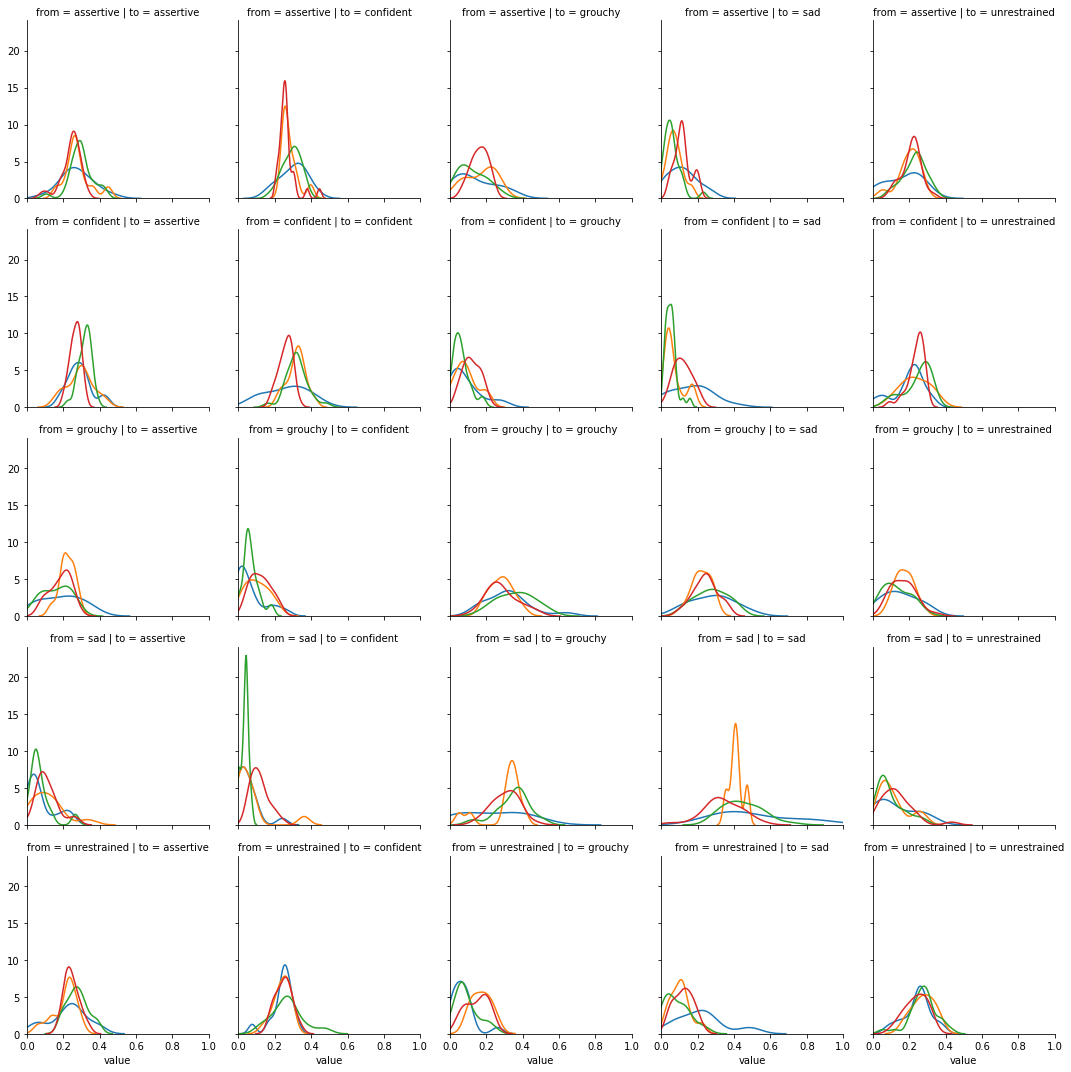

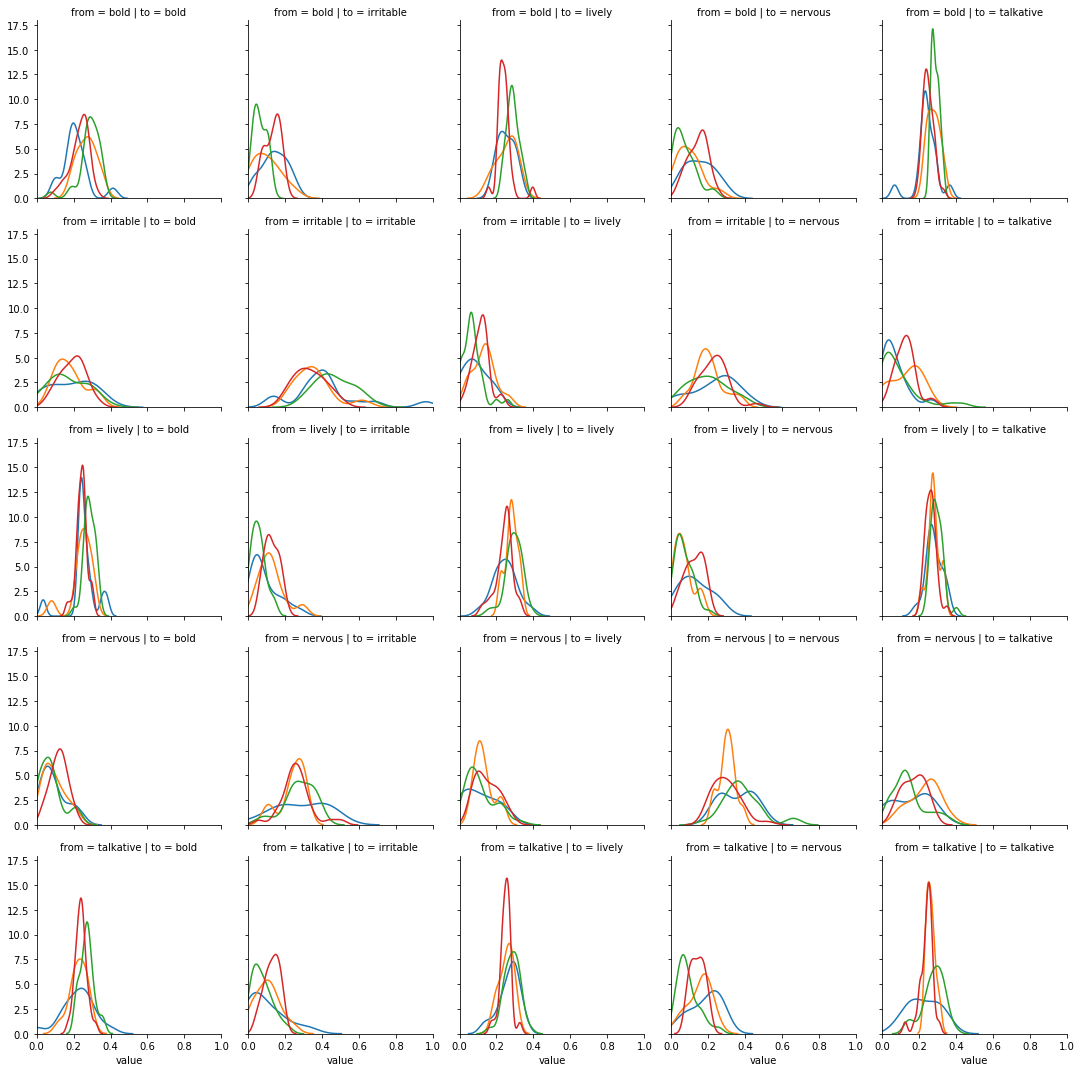

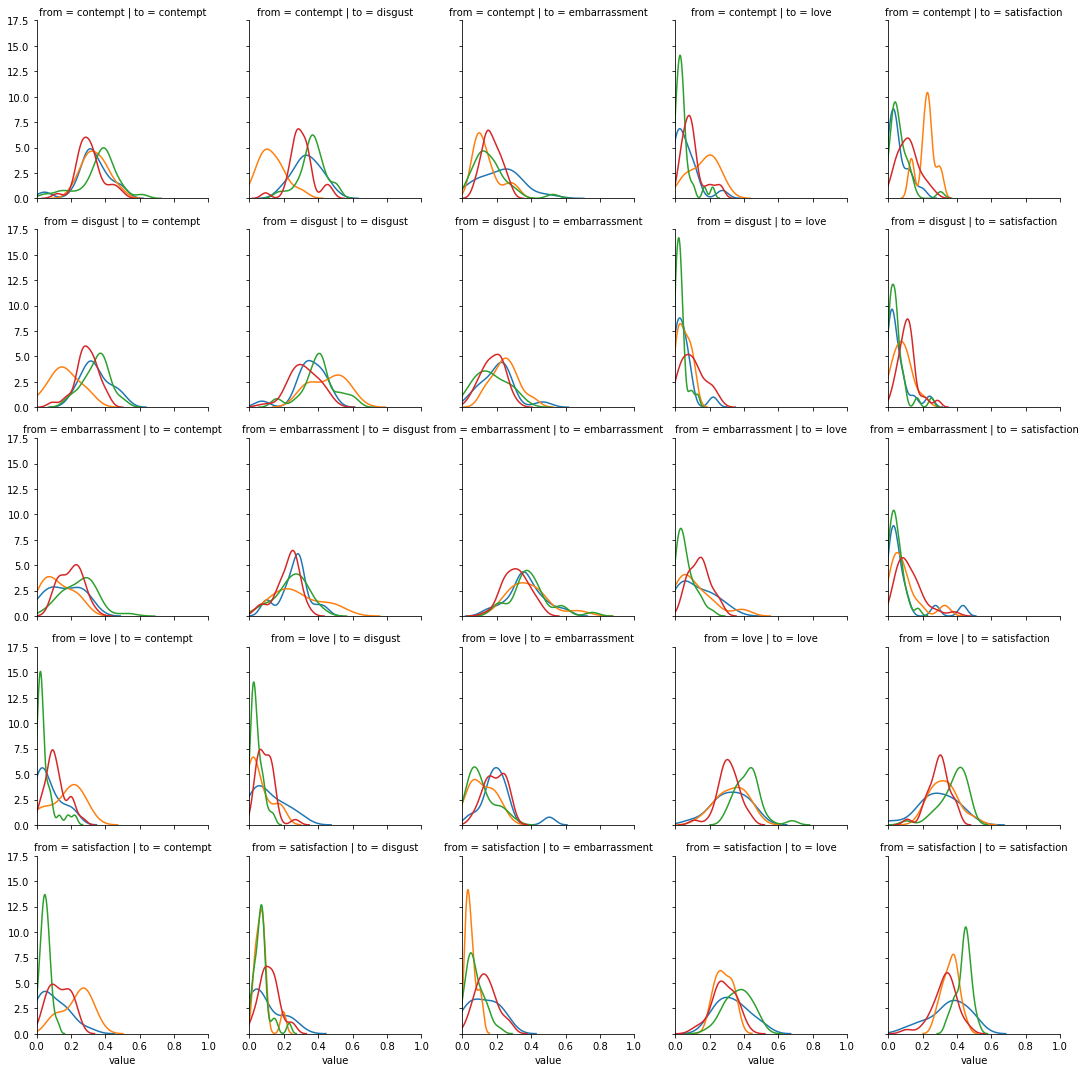

In [11]:
# fig = plt.figure()
# nrow = 15
# ncol = 5
# for i in np.arange(nrow):
#     for j in np.arange(ncol):
# #         print('i: {}, j:{}'.format(i,j))
#         img_ind = i*ncol + j + 1
# #         print(img_ind)
#         ax = fig.add_subplot(ncol,nrow,img_ind)
#         sns.distplot(tself_norm_all_3d[:,i,j],ax = ax)
# plt.show()

draw_density_better(map_self_norm_all, mem_self_norm_all)

### MCMC

In [ ]:
posterior_samples_self_norm_all = tomtom_mcmc(seed_self_norm_all)
posterior_samples_self_norm_all['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_self_norm_all['weights'][:,1]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

## Normalized, no Autotransitions

### SVI

In [12]:
K = 10
target = 'self' # 'self','targ','avg'
norm = 'norm' # 'norm','raw'
auto = 'noauto' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [13]:
seed_self_norm_noauto, map_self_norm_noauto, mem_self_norm_noauto = tomtom_svi()

running SVI with: tself_norm_noauto_3d
seed = 70, initial_loss = 4190.841796875
..............................
 final loss: -3063.47509765625

weights = [0.22909598 0.04442924 0.01852454 0.02879906 0.20506206 0.10591576
 0.05880858 0.00641407 0.06248571]
mixed weights = tensor([0.2291, 0.0343, 0.0136, 0.0208, 0.1440, 0.0591, 0.0293, 0.0030, 0.0292,
        0.4375], grad_fn=<MulBackward0>)
concentration = [[[ 5.052569    1.8655124   1.0401579   2.83319   ]
  [ 1.1974862   1.289326    7.6502023   5.449879  ]
  [ 0.8772985   3.5834322   1.9241018   1.8777429 ]
  [ 1.3033121   6.348976    1.3188512   1.5082395 ]
  [ 2.9951684   1.3045691   0.8643857   2.6147752 ]
  [ 0.9226119   0.99843585  4.1614633   4.002313  ]
  [ 1.2571956   1.1093059   1.4012549   0.779575  ]
  [ 1.4978709   1.2344615   6.166453    6.8152323 ]
  [ 2.0968      1.1432514   0.9354964   1.450801  ]
  [ 2.0985956   1.66921     4.9986043   3.7104177 ]
  [ 1.1484615   0.78277904  4.2517867   1.7232466 ]
  [ 0.7446361   0.93

torch.Size([3]) clusters satisfy the filter requirement of having a mixture weight >= 0.1

these clusters contain 86 out of the 94 total observations
cluster 0 contains 35 observations
cluster 4 contains 45 observations
cluster 9 contains 6 observations


C:\Users\zhaoz\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.



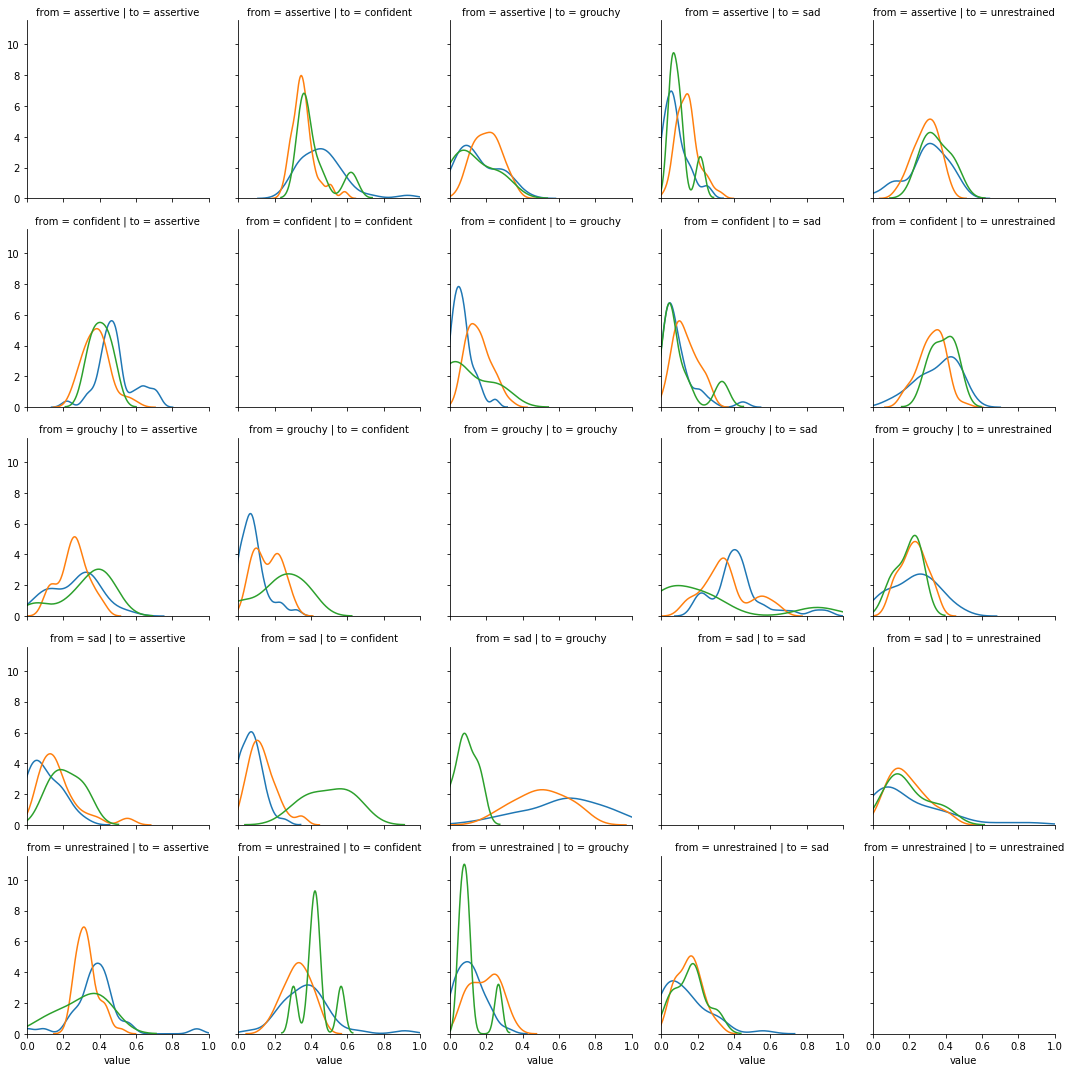

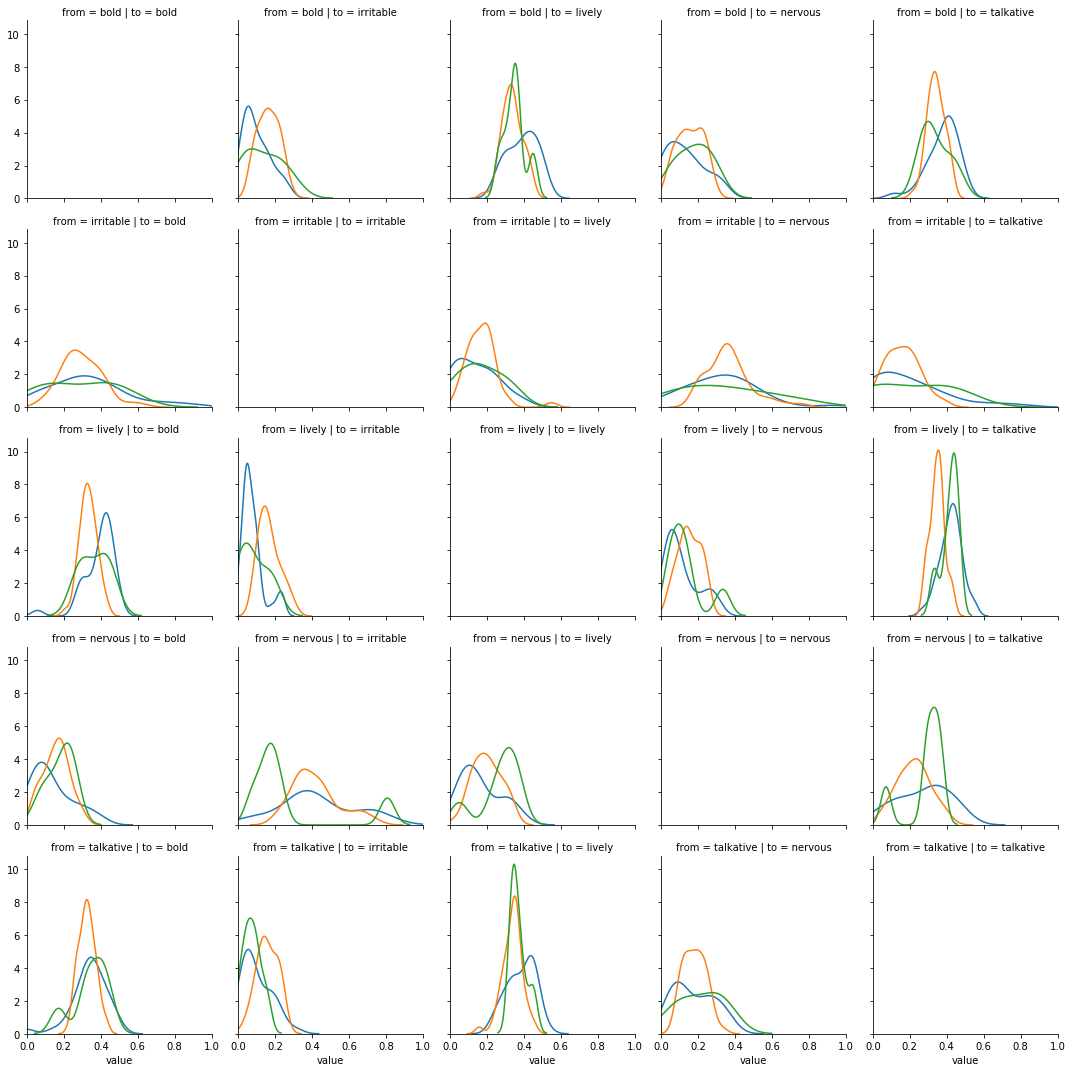

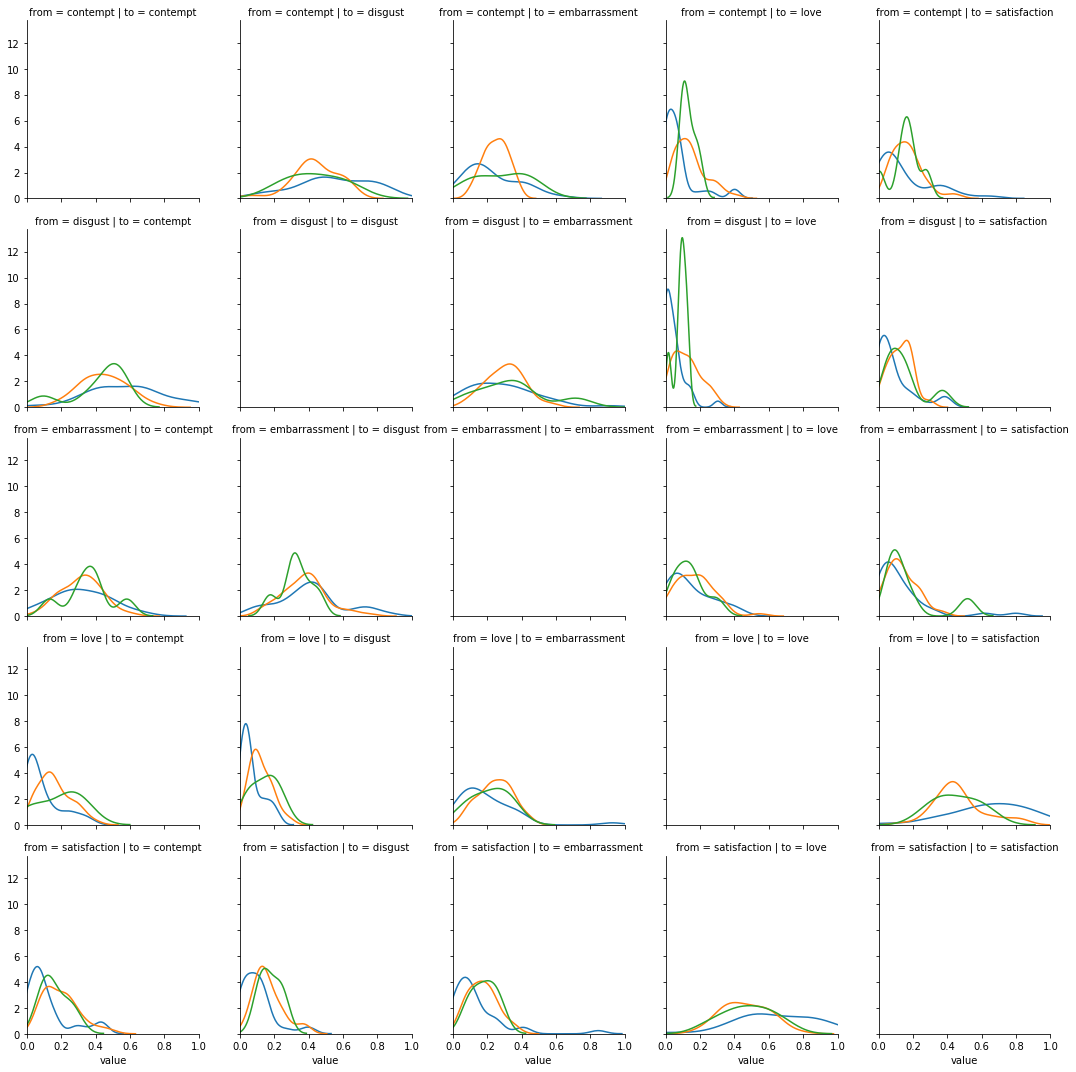

In [14]:
draw_density_better(map_self_norm_noauto, mem_self_norm_noauto)

### MCMC

In [ ]:
posterior_samples_self_norm_noauto = tomtom_mcmc(seed_self_norm_noauto)
posterior_samples_self_norm_noauto['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_self_norm_noauto['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

## Raw, with autotransitions

### SVI

In [15]:
K = 10
target = 'self' # 'self','targ','avg'
norm = 'raw' # 'norm','raw'
auto = 'all' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [16]:
seed_self_raw_all, map_self_raw_all, mem_self_raw_all = tomtom_svi()

running SVI with: tself_raw_all_3d
seed = 39, initial_loss = 29406.078125
..............................
 final loss: 65.9453125

weights = [0.02959727 0.07878206 0.08694548 0.09523138 0.35162312 0.02779024
 0.18778497 0.02282786 0.0769202 ]
mixed weights = tensor([0.0296, 0.0765, 0.0777, 0.0777, 0.2597, 0.0133, 0.0874, 0.0086, 0.0284,
        0.3410], grad_fn=<MulBackward0>)
alphas = [[[ 6.1491513   2.6667466   2.1856017   1.1955339   3.0169652 ]
  [ 1.9877744   3.5632958   1.8403833   5.5581317   5.222498  ]
  [ 1.1636729   3.1287844   1.3584876   4.286736    4.5150485 ]
  [ 6.1937947   2.4292626   1.7603024   3.2093754   1.851621  ]
  [ 1.525671    1.1263292   3.2622893   3.049369    2.1163826 ]
  [ 2.1271307   3.0367985   4.639405    1.6631238   5.9408083 ]
  [ 1.3450992   6.103649    3.145834    2.935225    1.2783314 ]
  [ 3.2874541   4.489965    2.8357854   3.9545543   7.0924687 ]
  [ 5.208816    3.5578828   5.650106    5.960313    5.8128004 ]
  [ 4.692677    2.3498049   3.403648

torch.Size([2]) clusters satisfy the filter requirement of having a mixture weight >= 0.1

these clusters contain 42 out of the 94 total observations
cluster 4 contains 39 observations
cluster 9 contains 3 observations


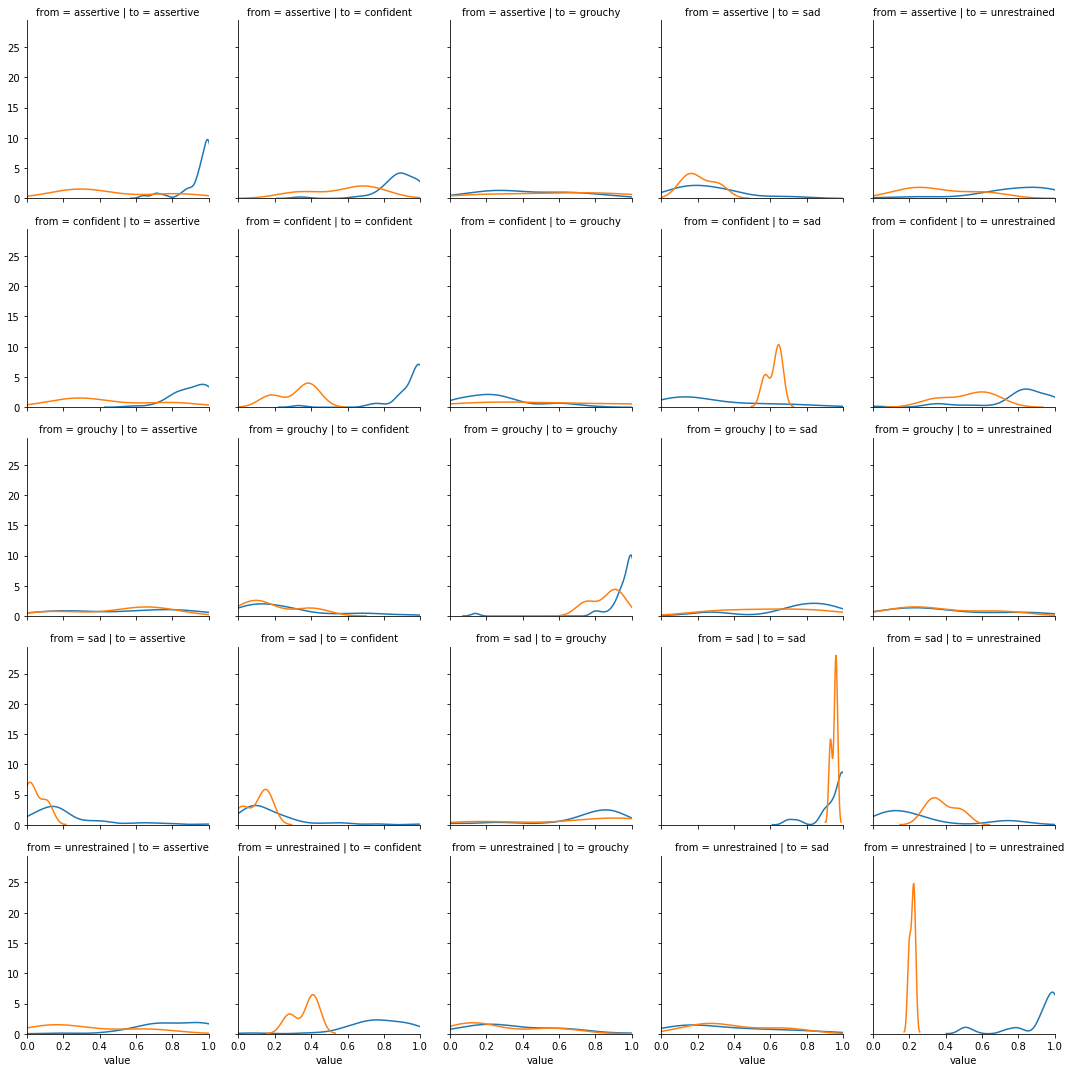

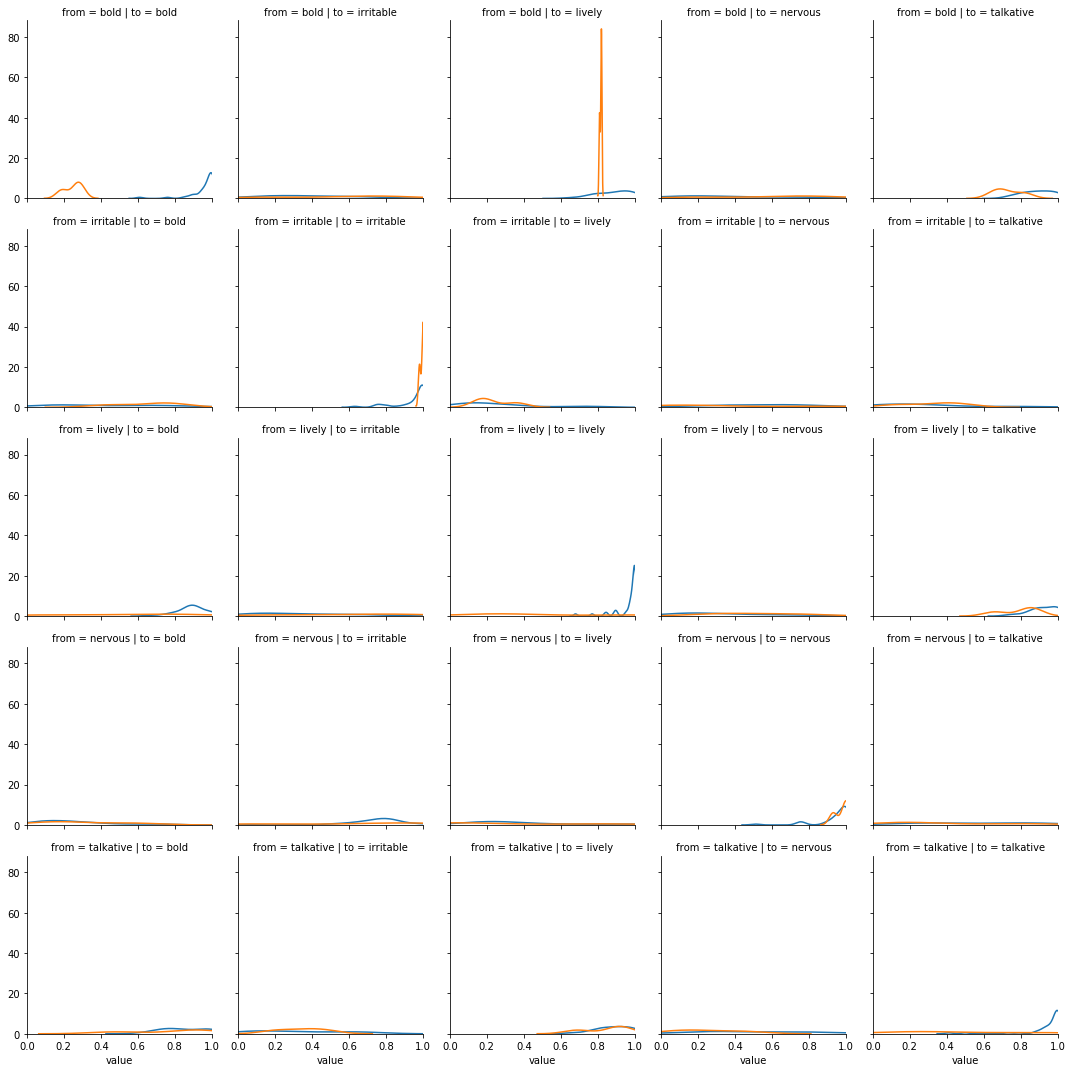

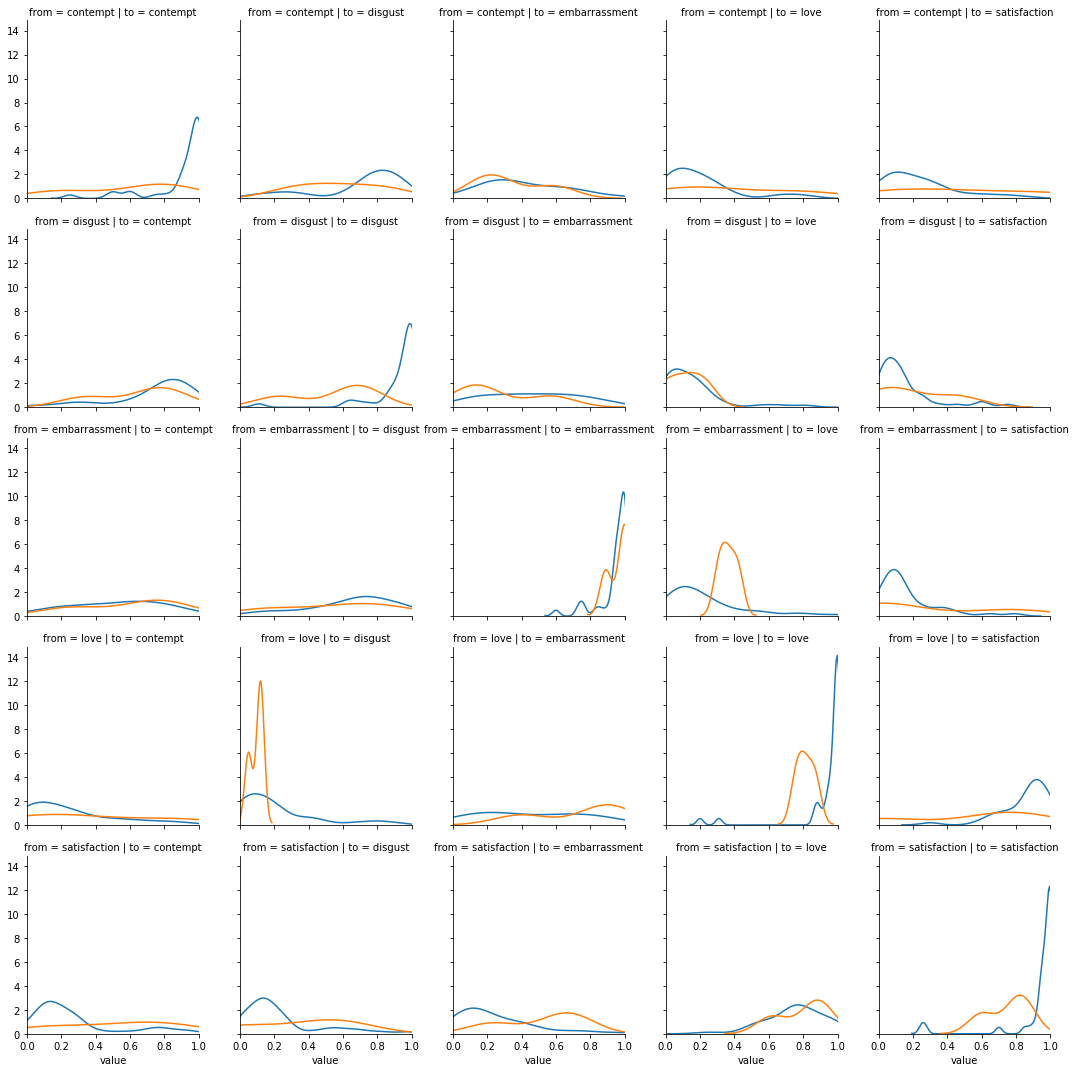

In [17]:
draw_density_better(map_self_raw_all, mem_self_raw_all)

### MCMC

In [ ]:
posterior_samples_self_raw_all = tomtom_mcmc(seed_self_raw_all)
posterior_samples_self_raw_all['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_self_raw_all['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

## Raw, without autotransitions

### SVI

In [18]:
K = 10
target = 'self' # 'self','targ','avg'
norm = 'raw' # 'norm','raw'
auto = 'noauto' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [19]:
seed_self_raw_noauto, map_self_raw_noauto, mem_self_raw_noauto = tomtom_svi()

running SVI with: tself_raw_noauto_3d
seed = 76, initial_loss = 18385.923828125
..............................
 final loss: 227.167724609375

weights = [0.2087543  0.25873637 0.13555959 0.03503329 0.0256704  0.05273004
 0.08343931 0.31180054 0.31239802]
mixed weights = tensor([0.2088, 0.2047, 0.0795, 0.0178, 0.0126, 0.0251, 0.0377, 0.1290, 0.0890,
        0.1959], grad_fn=<MulBackward0>)
alphas = [[[ 6.4129577   3.2452707   2.5398426   3.5527112 ]
  [ 1.1801035   1.3315053   5.8791404   4.7751327 ]
  [ 1.4375957   2.2992225   1.9867785   2.140252  ]
  [ 0.98341215  4.1701517   1.4189829   1.4066058 ]
  [ 4.3171206   2.4043372   3.079648    3.438308  ]
  [ 1.6632667   1.5614526   5.4242973   6.3567786 ]
  [ 2.2230413   1.6997273   3.0202465   1.001577  ]
  [ 1.7062315   2.4780033   4.072004    6.9982657 ]
  [ 3.3245897   1.5337052   2.1371386   1.5585015 ]
  [ 2.8096793   1.8617179   6.61055     5.1812043 ]
  [ 1.6255692   1.6749431   2.0829177   3.2625012 ]
  [ 2.2400947   1.3413061   

torch.Size([4]) clusters satisfy the filter requirement of having a mixture weight >= 0.1

these clusters contain 74 out of the 94 total observations
cluster 0 contains 29 observations
cluster 1 contains 28 observations
cluster 7 contains 16 observations
cluster 9 contains 1 observations


C:\Users\zhaoz\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.



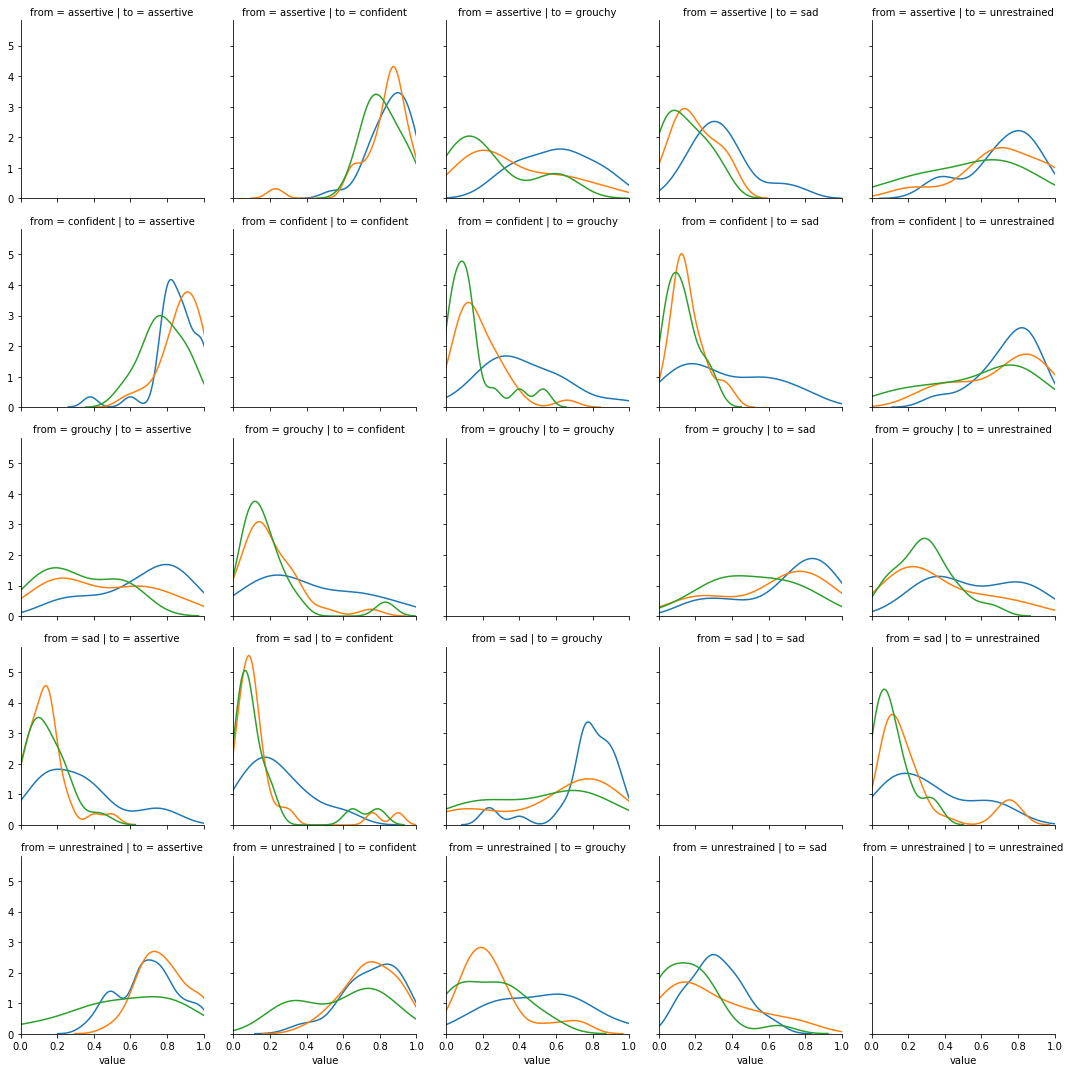

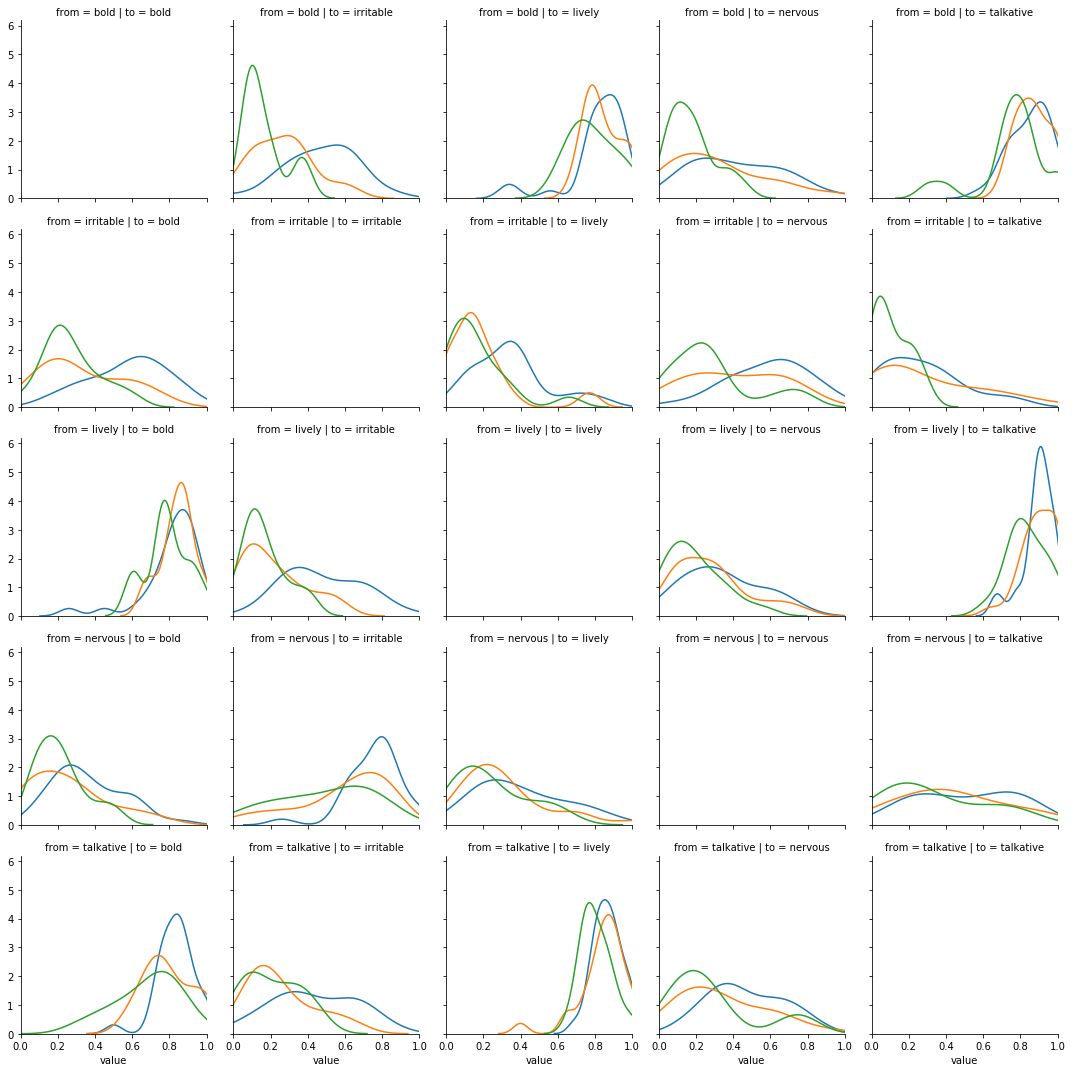

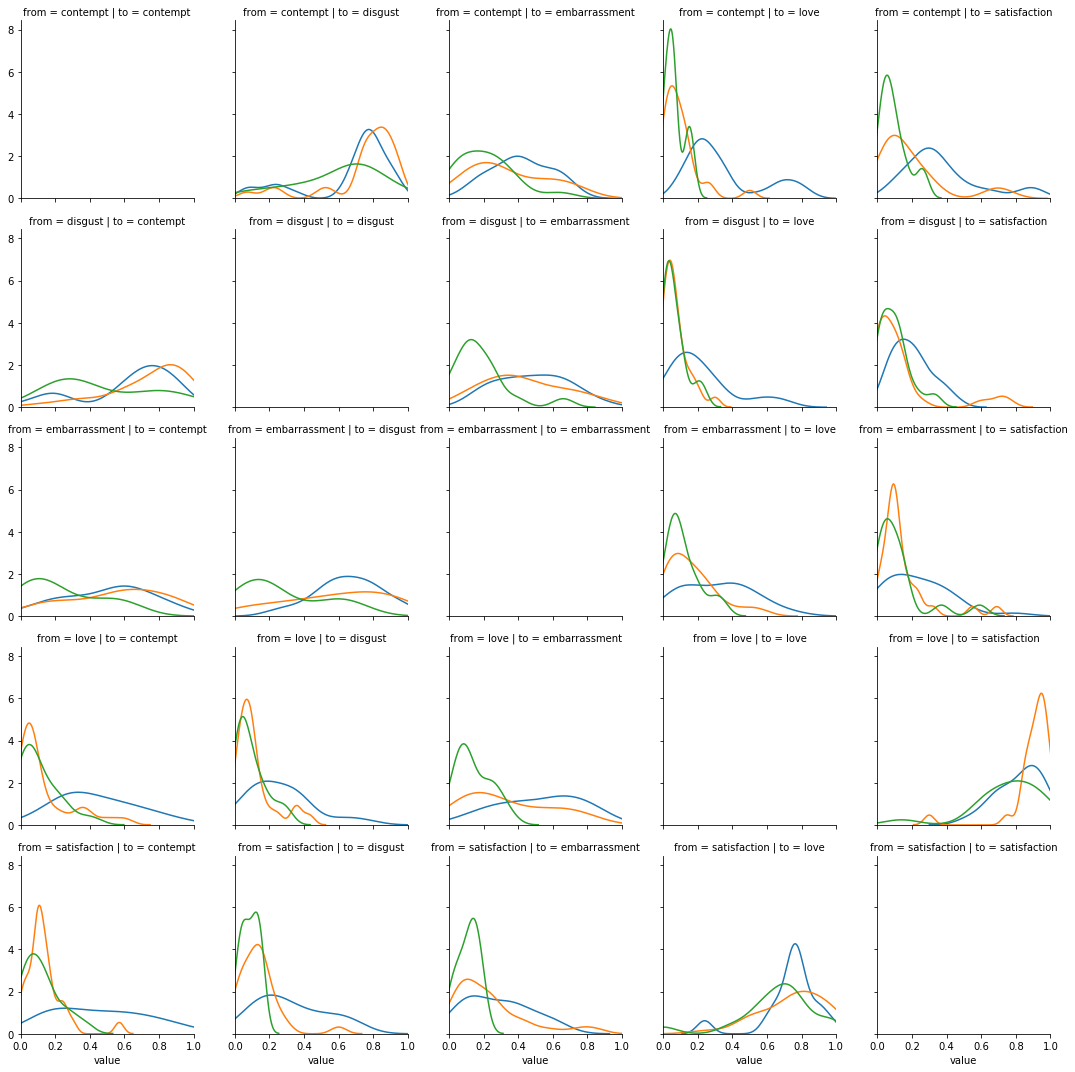

In [20]:
draw_density_better(map_self_raw_noauto, mem_self_raw_noauto)

### MCMC

In [ ]:
posterior_samples_self_raw_noauto = tomtom_mcmc(seed_self_raw_noauto)
posterior_samples_self_raw_noauto['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_self_raw_noauto['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

# Target-specific ratings

## Visual Inspections

In [ ]:
random.seed(200506)
# umap visualization
# rudimentary test run of umap on self transition data
fit_trans_targ_default = umap.UMAP()
u_trans_targ_default = fit_trans_targ_default.fit_transform(trans_targ)

In [ ]:
plt.scatter(u_trans_targ_default[:,0],u_trans_targ_default[:,1])

In [ ]:
fit_trans_targ_neighbor30 = umap.UMAP(n_neighbors=30,min_dist=0.05)
u_trans_targ_neighbor30 = fit_trans_targ_neighbor30.fit_transform(trans_targ)
plt.scatter(u_trans_targ_neighbor30[:,0],u_trans_targ_neighbor30[:,1])

In [ ]:
# pca to see how many dimensions best capture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
trans_targ_scaled = scaler.fit_transform(trans_targ)
decomp = PCA()
trans_targ_pca = decomp.fit(trans_targ_scaled)
plt.scatter(list(range(np.shape(trans_targ_pca.explained_variance_ratio_)[0])),np.array(trans_targ_pca.explained_variance_ratio_))

In [ ]:
# above pca result suggests 4-6 factors
# here we construct a new umap object with 3 dimensions and visulize it to see if there are obv clusters
fit_trans_targ_3d = umap.UMAP(n_neighbors=47,min_dist=0,n_components=3)
u_trans_targ_3d = fit_trans_targ_3d.fit_transform(trans_targ)

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

trace = go.Scatter3d(
    x=u_trans_targ_3d[:,0],  # <-- Put your data instead
    y=u_trans_targ_3d[:,1],  # <-- Put your data instead
    z=u_trans_targ_3d[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
        #'color': ,
    }
)
# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)
data = [trace]

plot_figure = go.Figure(data=data, layout=layout)
# Render the plot.
plotly.offline.iplot(plot_figure)

## Target specific ratings, normalized, with autotransitions

### SVI

In [ ]:
K = 10
target = 'targ' # 'self','targ','avg'
norm = 'norm' # 'norm','raw'
auto = 'all' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
seed_targ_norm_all, map_targ_norm_all, mem_targ_norm_all = tomtom_svi()

In [ ]:
draw_density(map_targ_norm_all, mem_targ_norm_all)

### MCMC

In [ ]:
posterior_samples_targ_norm_all = tomtom_mcmc(seed_targ_norm_all)
posterior_samples_targ_norm_all['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_targ_norm_all['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

## Target specific ratings, normalized, No autotransitions

### SVI

In [ ]:
K = 10
target = 'targ' # 'self','targ','avg'
norm = 'norm' # 'norm','raw'
auto = 'noauto' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
seed_targ_norm_noauto, map_targ_norm_noauto, mem_targ_norm_noauto = tomtom_svi()

In [ ]:
draw_density(map_targ_norm_noauto, mem_targ_norm_noauto)

### MCMC

In [ ]:
posterior_samples_targ_norm_noauto = tomtom_mcmc(seed_targ_norm_noauto)
posterior_samples_targ_norm_noauto['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_targ_norm_noauto['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

## Target specific ratings, Raw, with autotransitions

### SVI

In [ ]:
K = 10
target = 'targ' # 'self','targ','avg'
norm = 'raw' # 'norm','raw'
auto = 'all' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
seed_targ_raw_all, map_targ_raw_all, mem_targ_raw_all = tomtom_svi()

In [ ]:
draw_density(map_targ_raw_all, mem_targ_raw_all)

### MCMC

In [ ]:
posterior_samples_targ_raw_all = tomtom_mcmc(seed_targ_raw_all)
posterior_samples_targ_raw_all['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_targ_raw_all['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

## Target specific ratings, Raw, No autotransitions

### SVI

In [ ]:
K = 10
target = 'targ' # 'self','targ','avg'
norm = 'raw' # 'norm','raw'
auto = 'noauto' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
seed_targ_raw_noauto, map_targ_raw_noauto, mem_targ_raw_noauto = tomtom_svi()

In [ ]:
draw_density(map_targ_raw_noauto, mem_targ_raw_noauto)

### MCMC

In [ ]:
posterior_samples_targ_raw_noauto = tomtom_mcmc(seed_targ_raw_noauto)
posterior_samples_targ_raw_noauto['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_targ_raw_noauto['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

# Group level ratings

## Visual Inspections

In [ ]:
random.seed(200506)
# umap visualization
# rudimentary test run of umap on self transition data
fit_trans_avg_default = umap.UMAP()
u_trans_avg_default = fit_trans_avg_default.fit_transform(trans_avg)

In [ ]:
plt.scatter(u_trans_avg_default[:,0],u_trans_avg_default[:,1])

In [ ]:
fit_trans_avg_neighbor30 = umap.UMAP(n_neighbors=30,min_dist=0.05)
u_trans_avg_neighbor30 = fit_trans_avg_neighbor30.fit_transform(trans_avg)
plt.scatter(u_trans_avg_neighbor30[:,0],u_trans_avg_neighbor30[:,1])

In [ ]:
# pca to see how many dimensions best capture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
trans_avg_scaled = scaler.fit_transform(trans_avg)
decomp = PCA()
trans_avg_pca = decomp.fit(trans_avg_scaled)
plt.scatter(list(range(np.shape(trans_avg_pca.explained_variance_ratio_)[0])),np.array(trans_avg_pca.explained_variance_ratio_))

In [ ]:
# above pca result suggests 4-6 factors
# here we construct a new umap object with 3 dimensions and visulize it to see if there are obv clusters
fit_trans_avg_3d = umap.UMAP(n_neighbors=47,min_dist=0,n_components=3)
u_trans_avg_3d = fit_trans_avg_3d.fit_transform(trans_avg)

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

trace = go.Scatter3d(
    x=u_trans_avg_3d[:,0],  # <-- Put your data instead
    y=u_trans_avg_3d[:,1],  # <-- Put your data instead
    z=u_trans_avg_3d[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
        #'color': ,
    }
)
# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)
data = [trace]

plot_figure = go.Figure(data=data, layout=layout)
# Render the plot.
plotly.offline.iplot(plot_figure)

## Group level ratings, normalized, with autotransitions

### SVI

In [ ]:
K = 10
target = 'avg' # 'self','targ','avg'
norm = 'norm' # 'norm','raw'
auto = 'all' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
seed_avg_norm_all, map_avg_norm_all, mem_avg_norm_all = tomtom_svi()

In [ ]:
draw_density(map_avg_norm_all, mem_avg_norm_all)

### MCMC

In [ ]:
posterior_samples_avg_norm_all = tomtom_mcmc(seed_avg_norm_all)
posterior_samples_avg_norm_all['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_avg_norm_all['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

## Group level ratings, normalized, No autotransitions

### SVI

In [ ]:
K = 10
target = 'avg' # 'self','targ','avg'
norm = 'norm' # 'norm','raw'
auto = 'noauto' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
seed_avg_norm_noauto, map_avg_norm_noauto, mem_avg_norm_noauto = tomtom_svi()

In [ ]:
draw_density(map_avg_norm_noauto, mem_avg_norm_noauto)

### MCMC

In [ ]:
posterior_samples_avg_norm_noauto = tomtom_mcmc(seed_avg_norm_noauto)
posterior_samples_avg_norm_noauto['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_avg_norm_noauto['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

## Group level ratings, Raw, with autotransitions

### SVI

In [ ]:
K = 10
target = 'avg' # 'self','targ','avg'
norm = 'raw' # 'norm','raw'
auto = 'all' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
seed_avg_raw_all, map_avg_raw_all, mem_avg_raw_all = tomtom_svi()

In [ ]:
draw_density(map_avg_raw_all, mem_avg_raw_all)

### MCMC

In [ ]:
posterior_samples_avg_raw_all = tomtom_mcmc(seed_avg_raw_all)
posterior_samples_avg_raw_all['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_avg_raw_all['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

## Group level ratings, Raw, No autotransitions

### SVI

In [ ]:
K = 10
target = 'avg' # 'self','targ','avg'
norm = 'raw' # 'norm','raw'
auto = 'noauto' # 'noauto','all'
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
seed_avg_raw_noauto, map_avg_raw_noauto, mem_avg_raw_noauto = tomtom_svi()

In [ ]:
draw_density(map_avg_raw_noauto, mem_avg_raw_noauto)

### MCMC

In [ ]:
posterior_samples_avg_raw_noauto = tomtom_mcmc(seed_avg_raw_noauto)
posterior_samples_avg_raw_noauto['weights'].shape

In [ ]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples_avg_raw_noauto['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

# Topic model-y tryout

In [21]:
@config_enumerate()
def model_topic(data):
    num_topics = 2
    nrow = data.shape[1]
    ncol = data.shape[2]
    print(nrow,ncol)

    with pyro.plate('topic', num_topics):
        # sample a weight and value for each topic
        topic_weights = pyro.sample("topic_weights", dist.Gamma(1. / num_topics, 1.))
        topic_concentrations = pyro.sample("topic_values", dist.Gamma(2 * torch.ones(nrow,ncol), 1/3 * torch.ones(nrow,ncol)).to_event(2))
        print('topic weights', topic_weights.shape)
        print('topic values', topic_concentrations.shape)

    with pyro.plate('participants', data.shape[0]):
        # sample each participant's idiosyncratic topic mixture
        participant_topics = pyro.sample("participant_topics", dist.Dirichlet(topic_weights))
        print('participant topics', participant_topics.shape)
        
        transition_topics = pyro.sample("transition_topics", dist.Categorical(participant_topics),
                                        infer={"enumerate": "parallel"})
        print('topics')
        print('transition topics', transition_topics.shape)

        out = dist.Dirichlet(topic_concentrations[transition_topics]).to_event(1)
        print('observation batch:', out.batch_shape)
        print('observation event:', out.event_shape)
        print('data', data.shape)
        data = pyro.sample("obs", dist.Dirichlet(topic_concentrations[transition_topics]),
                    obs=data)
        print(data)

In [22]:
model_topic(tself_norm_all_3d)

15 5
topic weights torch.Size([2])
topic values torch.Size([2, 15, 5])
participant topics torch.Size([94, 2])
topics
transition topics torch.Size([94])
observation batch: torch.Size([94])
observation event: torch.Size([15, 5])
data torch.Size([94, 15, 5])


ValueError: Shape mismatch inside plate('participants') at site obs dim -1, 94 vs 15